Nifty tutorial for 2D dust
=====================================

Setup
-----

In [9]:
#!/usr/bin/env python3

# Copyright(C) 2013-2021 Max-Planck-Society
# SPDX-License-Identifier: GPL-2.0+ OR BSD-2-Clause

# %% [markdown]
# # 3D Tomography Example with known start- and end-points

# %%

import jax
import matplotlib.pyplot as plt
import nifty8.re as jft
import numpy as np
from jax import numpy as jnp
from jax import random

jax.config.update("jax_enable_x64", True)

# %%
key = random.PRNGKey(1)

## Define the geometry of the problem
dims = (128, 128)
distances = tuple(1.0 / d for d in dims)


Initialzing the field models
---------------------------

In [10]:
cfm_logamp = jft.CorrelatedFieldMaker("logamp")
cfm_logamp.set_amplitude_total_offset(offset_mean=2, offset_std=(1e-1, 3e-2))
cfm_logamp.add_fluctuations(  # Axis over which the kernle is defined
    dims,
    distances=distances,
    fluctuations=(1.0, 5e-1),
    loglogavgslope=(-5.0, 2e-1),
    flexibility=(1e0, 2e-1),
    asperity=(5e-1, 5e-2),
    prefix="logamp",
    non_parametric_kind="power",
)
logamp_model = cfm_logamp.finalize()  # forward model for a GP prior foir the log-amplitude of the RMSky

cfm_sign = jft.CorrelatedFieldMaker("sign")
cfm_sign.set_amplitude_total_offset(offset_mean=0, offset_std=(1e-1, 3e-2))
cfm_sign.add_fluctuations(  # Axis over which the kernle is defined
    dims,
    distances=distances,
    fluctuations=(1.0, 5e-1),
    loglogavgslope=(-5.0, 2e-1),
    flexibility=(1e0, 2e-1),
    asperity=(5e-1, 5e-2),
    prefix="sign",
    non_parametric_kind="power",
)
sign_model = cfm_sign.finalize()  # forward model for a GP prior foir the cfm_sign of the RMSky


Draw synthetic end points and initialize the repository
-------------------------------------------------------

In [11]:
# %%
# 

from projector import PlaneProjector

n_synth_points = 100
key, sk = random.split(key)
points = random.uniform(
    sk,
    (n_synth_points, len(dims)),
    minval=0.05,
    maxval=0.95,
)

proj = PlaneProjector(x=points[:, 0], y=points[:, 1], fov_shape=dims, fov_resolution=distances, reference_point=(0, 0))


Build forward model
-------------------

In [12]:
class RMForward(jft.Model):
    def __init__(self, log_amplitude, sign, projector):
        self.log_amplitude = log_amplitude
        self.sign = sign
        self.projector = projector
        # Track a method with which a random input for the model. This is not
        # strictly required but is usually handy when building deep models.
        super().__init__(init=log_amplitude.init | sign.init )

    def RMSky(self, x):
        # Helper function to compute the RMSky
        return jnp.exp(self.log_amplitude(x))* self.sign(x)

    def __call__(self, x):
        return self.projector(jnp.exp(self.log_amplitude(x))* self.sign(x))


forward = RMForward(logamp_model, sign_model, proj)

Draw synthetic data
-------------------

In [13]:
# %%
key, k_f, k_n = random.split(key, 3)
synth_pos = forward.init(k_f)
synth_truth = forward(synth_pos)
noise_scl = 0.15
synth_noise = random.normal(k_n, synth_truth.shape, synth_truth.dtype)
synth_noise = synth_noise * noise_scl * synth_truth
synth_data = synth_truth + synth_noise


The likelihood
--------------

In [14]:
lh = jft.Gaussian(synth_data, noise_cov_inv=1.0 / synth_noise**2).amend(forward)

assuming the specified inverse covariance is diagonal
assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


The inference
-------------

In [15]:
# %%
n_vi_iterations = 6
delta = 1e-4
n_samples = 4

key, k_i, k_o = random.split(key, 3)
samples, state = jft.optimize_kl(
    lh,
    jft.Vector(lh.init(k_i)),
    n_total_iterations=n_vi_iterations,
    n_samples=lambda i: n_samples // 2 if i < 2 else n_samples,
    key=k_o,
    draw_linear_kwargs=dict(
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=100),
    ),
    nonlinearly_update_kwargs=dict(
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict(
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name="MCG"), maxiter=35
        )
    ),
    sample_mode="linear_resample",
    odir="results_tomography",
    resume=False,
)

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+2.1376e+07 Δ⛰:inf ➽:3.9254e-01
SL: Iteration 1 ⛰:+7.9684e+06 Δ⛰:1.3408e+07 ➽:3.9254e-01
SL: Iteration 2 ⛰:+5.0806e+05 Δ⛰:7.4604e+06 ➽:3.9254e-01
SL: Iteration 3 ⛰:+1.4472e+05 Δ⛰:3.6334e+05 ➽:3.9254e-01
SL: Iteration 4 ⛰:+1.6477e+04 Δ⛰:1.2824e+05 ➽:3.9254e-01
SL: Iteration 5 ⛰:+9.6047e+03 Δ⛰:6.8722e+03 ➽:3.9254e-01
SL: Iteration 6 ⛰:-7.0512e+02 Δ⛰:1.0310e+04 ➽:3.9254e-01
SL: Iteration 7 ⛰:-8.7698e+03 Δ⛰:8.0647e+03 ➽:3.9254e-01
SL: Iteration 8 ⛰:-8.8350e+03 Δ⛰:6.5225e+01 ➽:3.9254e-01
SL: Iteration 9 ⛰:-1.2367e+04 Δ⛰:3.5317e+03 ➽:3.9254e-01
SL: Iteration 10 ⛰:-1.2387e+04 Δ⛰:2.0227e+01 ➽:3.9254e-01
SL: Iteration 11 ⛰:-1.4385e+04 Δ⛰:1.9977e+03 ➽:3.9254e-01
SL: Iteration 12 ⛰:-1.6315e+04 Δ⛰:1.9307e+03 ➽:3.9254e-01
SL: Iteration 13 ⛰:-1.6327e+04 Δ⛰:1.1779e+01 ➽:3.9254e-01
SL: Iteration 14 ⛰:-1.6331e+04 Δ⛰:4.1561e+00 ➽:3.9254e-01
SL: Iteration 15 ⛰:-1.7184e+04 Δ⛰:8.5254e+02 ➽:3.9254e-01
SL: Iteration 16 ⛰:-1.7629e+04 Δ⛰:4.4551e+02 ➽:3.9254e-01
SL: 

Plot posterior
--------------

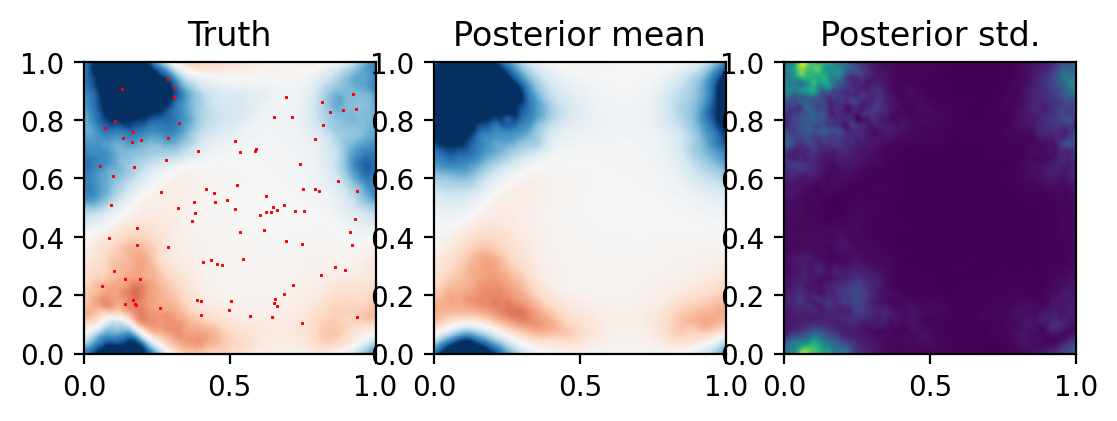

In [ ]:


# %%
synth_rm = forward.RMSky(synth_pos)
post_rm = jax.vmap(forward.RMSky)(samples.samples)

# %%
extent = (0, 1, 0, 1)
vmax = 0.6*jnp.max(abs(synth_rm))
fig, axs = plt.subplots(1, 3, dpi=200)
ax_t, ax_p, ax_ps = axs
ax_t.imshow(synth_rm, extent=extent, cmap="RdBu", vmax=vmax, vmin=-vmax)
ax_t.plot(
    *points[:].T,
    "+",
    markersize=0.5,
    color="red",
)

ax_p.imshow(post_rm.mean(axis=0), extent=extent, cmap="RdBu", vmax=vmax, vmin=-vmax)
ax_ps.imshow(post_rm.std(axis=0), extent=extent, cmap="viridis", vmax=vmax, vmin=0)
for title, ax in zip(("Truth", "Posterior mean", "Posterior std."), axs):
    ax.set_title(title)
fig.savefig("results_rm_projected_full_reconstruction.png", dpi=300)
plt.show()